In [25]:
import seaborn as sns
import pandas as pd
import os
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, make_scorer
from skopt import BayesSearchCV

In [26]:
default_path = "BlueFridgeNonLin"
three_state = pd.read_csv(f"three_state.csv")
three_state = three_state.drop(columns="Unnamed: 0")
three_state = three_state.sample(frac=1, random_state=42).reset_index(drop=True)

# Define features (X) and labels (y)
X = three_state.drop(columns=["label"])  # All columns except "label"
y = three_state["label"]  # Target labels

# Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [33]:
precision_scorer = make_scorer(precision_score, average="weighted")
# Initialize LightGBM model with default parameters
lgbm = lgb.LGBMClassifier(objective="multiclass", num_class=3, n_jobs=-1)

#hyperparameter tuning
param_serach = {
    "num_leaves": (20, 40),
    "learning_rate": (0.05, 0.3, "log-uniform"),
    "n_estimators": (50, 250),
    "max_depth": (2, 15),
    "min_child_samples": (10, 80),
    "subsample": (0.5, 1.0, "uniform"),
    "colsample_bytree": (0.1, 1.0, "uniform"),
}

cv = StratifiedKFold(n_splits=5, shuffle=True)

bayes_search = BayesSearchCV(
    estimator = lgbm,
    search_spaces= param_serach,
    n_iter=10,
    scoring=precision_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=0,
)

bayes_search.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 147456, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
              estimator=LGBMClassifier(n_jobs=-1, num_class=3,
                                       objective='multiclass'),
              n_iter=10, n_jobs=-1,
              scoring=make_scorer(precision_score, response_method='predict', average=weighted),
              search_spaces={'colsample_bytree': (0.1, 1.0, 'uniform'),
                             'learning_rate': (0.05, 0.3, 'log-uniform'),
                             'max_depth': (2, 15),
                             'min_child_samples': (10, 80),
                             'n_estimators': (50, 250), 'num_leaves': (20, 40),
                             'subsample': (0.5, 1.0, 'uniform')})

In [34]:

# Train the model on full training data
best_lgbm = bayes_search.best_estimator_
best_lgbm.fit(X_train, y_train)

# Predict on test set
y_pred = best_lgbm.predict(X_test)

# Compute accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average="weighted")
conf_matrix = confusion_matrix( y_test, y_pred, normalize= 'true')
print(f"Best Hyperparameters: {bayes_search.best_params_}")
print(f"Best CV Score: {bayes_search.best_score_:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(conf_matrix)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 147456, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Best Hyperparameters: OrderedDict({'colsample_bytree': 0.9830651076283329, 'learning_rate': 0.07280456111650027, 'max_depth': 6, 'min_child_samples': 53, 'n_estimators': 98, 'num_leaves': 29, 'subsample': 0.7983500667810297})
Best CV Score: 0.8564
Test Precision: 0.8604
Test Accuracy: 0.8410
[[0.73157928 0.16067746 0.10774327]
 [0.04908742 0.89490874 0.05600384]
 [0.00679231 0.03836219 0.9548455 ]]


In [54]:
import joblib
# save model
joblib.dump(best_lgbm, 'lgb.pkl')

['lgb.pkl']

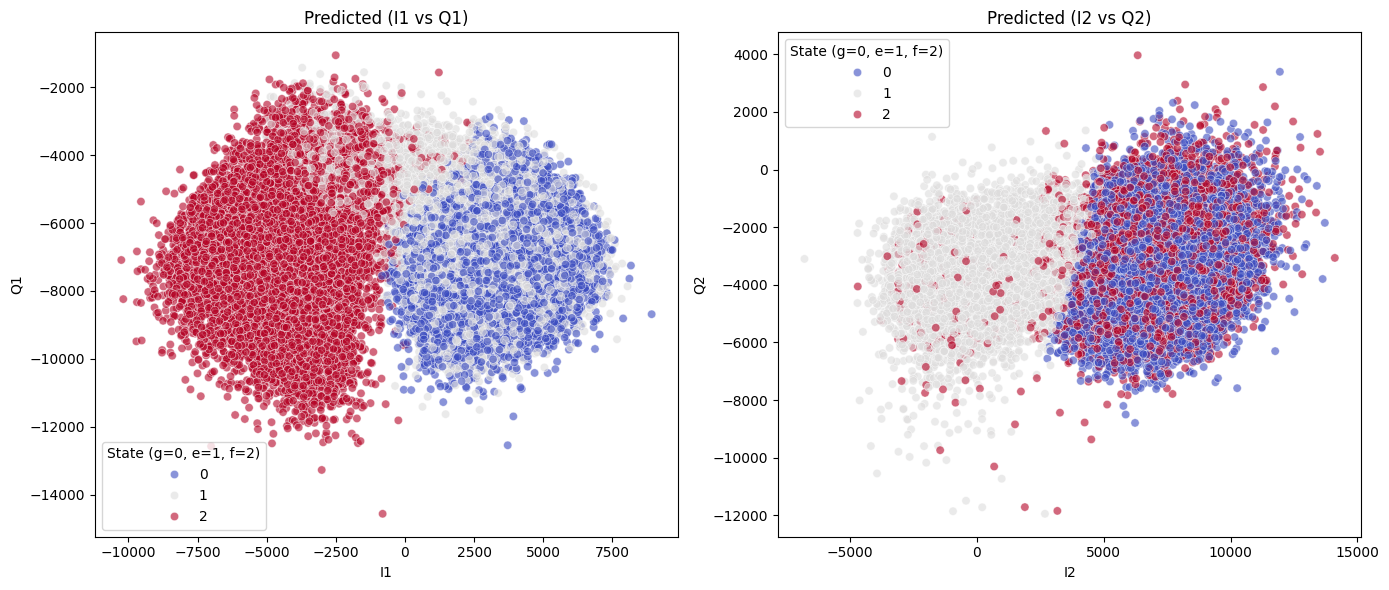

In [36]:
# Convert test data into a DataFrame for easier plotting
test_df = pd.DataFrame(X_test, columns=["I1", "Q1", "I2", "Q2"])
test_df["label"] = y_test  # Add true labels
test_df["predicted"] = y_pred  # Add predicted labels

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: I1 vs Q1
sns.scatterplot(
    data=test_df,
    x="I1",
    y="Q1",
    hue="predicted",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[0],
)
axes[0].set_xlabel("I1")
axes[0].set_ylabel("Q1")
axes[0].set_title("Predicted (I1 vs Q1)")
axes[0].legend(title="State (g=0, e=1, f=2)")

# Second subplot: I2 vs Q2
sns.scatterplot(
    data=test_df,
    x="I2",
    y="Q2",
    hue="predicted",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[1],
)
axes[1].set_xlabel("I2")
axes[1].set_ylabel("Q2")
axes[1].set_title("Predicted (I2 vs Q2)")
axes[1].legend(title="State (g=0, e=1, f=2)")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

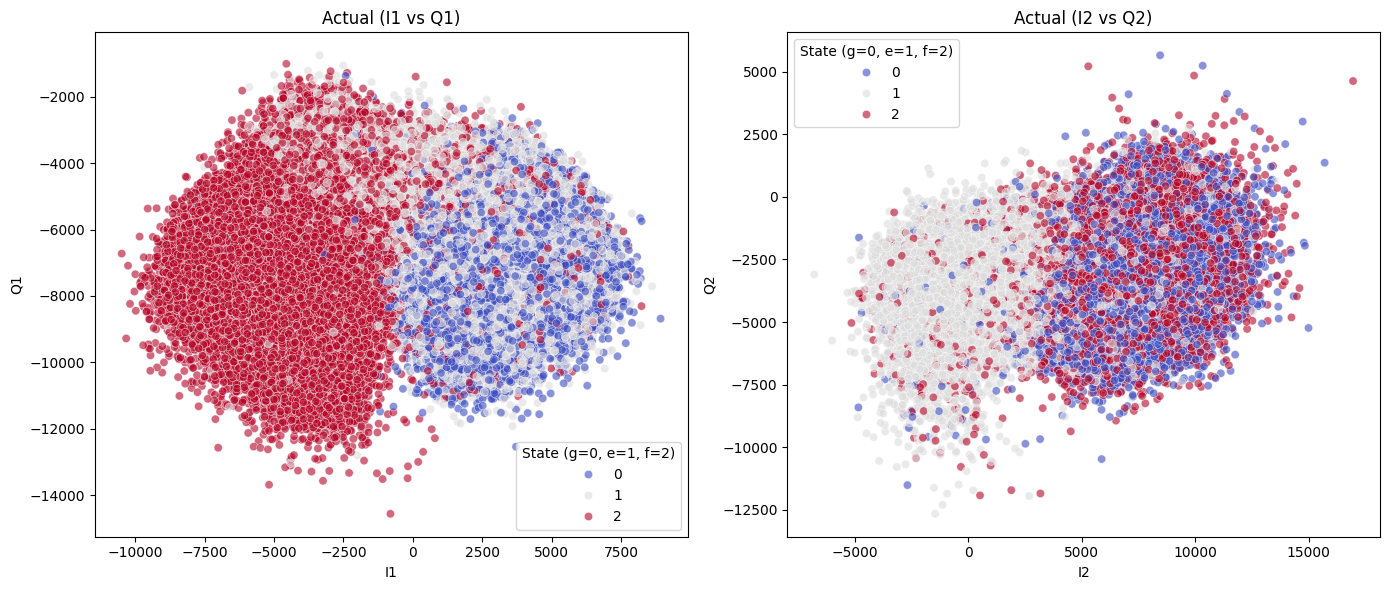

In [37]:
# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: I1 vs Q1
sns.scatterplot(
    data=three_state,
    x="I1",
    y="Q1",
    hue="label",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[0],
)
axes[0].set_xlabel("I1")
axes[0].set_ylabel("Q1")
axes[0].set_title("Actual (I1 vs Q1)")
axes[0].legend(title="State (g=0, e=1, f=2)")

# Second subplot: I2 vs Q2
sns.scatterplot(
    data=three_state,
    x="I2",
    y="Q2",
    hue="label",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[1],
)
axes[1].set_xlabel("I2")
axes[1].set_ylabel("Q2")
axes[1].set_title("Actual (I2 vs Q2)")
axes[1].legend(title="State (g=0, e=1, f=2)")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [46]:
new_data = pd.read_csv(f"three_state_pt2.csv")
new_data = new_data.drop(columns="Unnamed: 0")
new_data = new_data.sample(frac=1, random_state=42).reset_index(drop=True)
new_data_test = new_data.drop(columns="label")
new_data_label = new_data["label"]
# Predict on test set
new_pred = best_lgbm.predict(new_data_test)
print(confusion_matrix(new_data['label'],new_pred, normalize= 'true'))

[[0.95273969 0.04086947 0.00639084]
 [0.24514376 0.72506112 0.02979512]
 [0.14352811 0.05325255 0.80321933]]


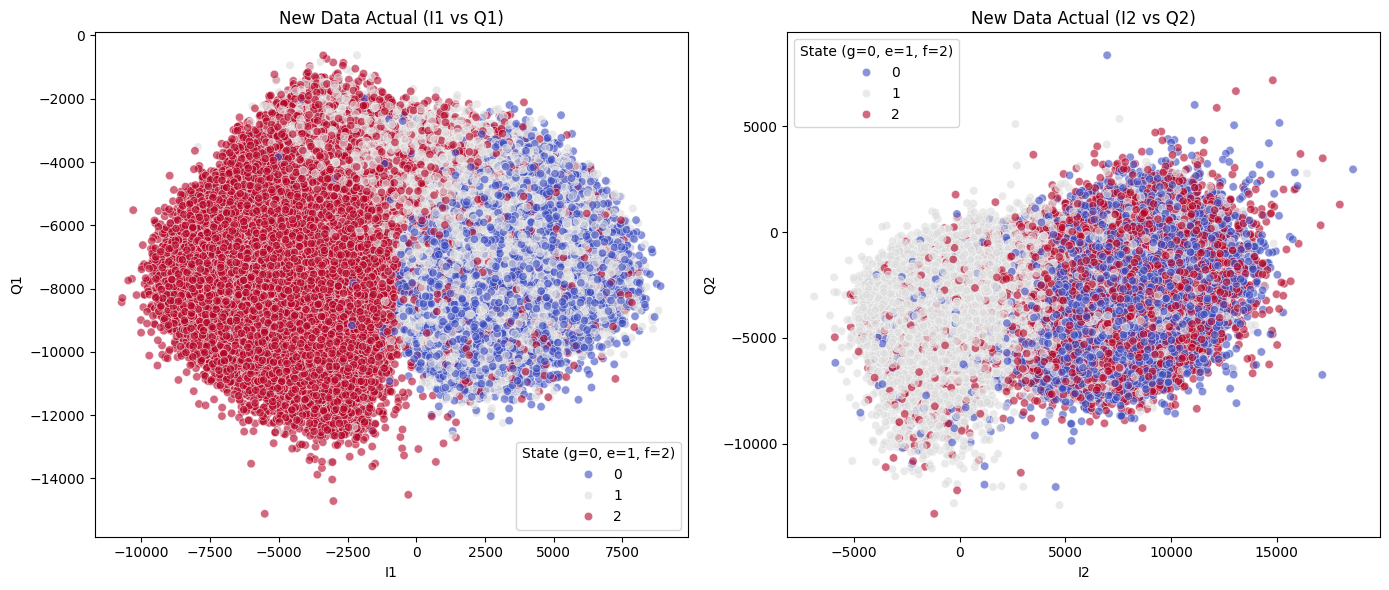

In [47]:
# Convert test data into a DataFrame for easier plotting
new_test_df = pd.DataFrame(new_data, columns=["I1", "Q1", "I2", "Q2", "label"])
new_test_df["predicted"] = new_pred  # Add predicted labels

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: I1 vs Q1
sns.scatterplot(
    data=new_test_df,
    x="I1",
    y="Q1",
    hue="label",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[0],
)
axes[0].set_xlabel("I1")
axes[0].set_ylabel("Q1")
axes[0].set_title("New Data Actual (I1 vs Q1)")
axes[0].legend(title="State (g=0, e=1, f=2)")

# Second subplot: I2 vs Q2
sns.scatterplot(
    data=new_test_df,
    x="I2",
    y="Q2",
    hue="label",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[1],
)
axes[1].set_xlabel("I2")
axes[1].set_ylabel("Q2")
axes[1].set_title("New Data Actual (I2 vs Q2)")
axes[1].legend(title="State (g=0, e=1, f=2)")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

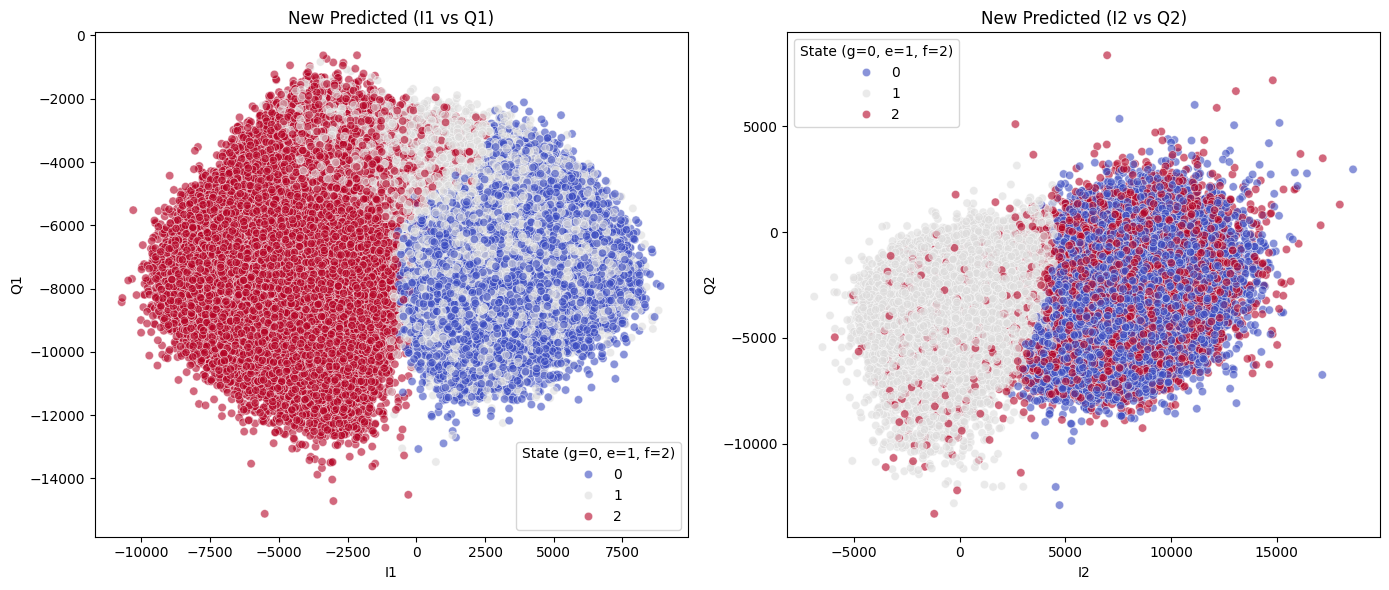

In [48]:
# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: I1 vs Q1
sns.scatterplot(
    data=new_test_df,
    x="I1",
    y="Q1",
    hue="predicted",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[0],
)
axes[0].set_xlabel("I1")
axes[0].set_ylabel("Q1")
axes[0].set_title("New Predicted (I1 vs Q1)")
axes[0].legend(title="State (g=0, e=1, f=2)")

# Second subplot: I2 vs Q2
sns.scatterplot(
    data=new_test_df,
    x="I2",
    y="Q2",
    hue="predicted",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[1],
)
axes[1].set_xlabel("I2")
axes[1].set_ylabel("Q2")
axes[1].set_title("New Predicted (I2 vs Q2)")
axes[1].legend(title="State (g=0, e=1, f=2)")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [49]:
conf_matrix = confusion_matrix(new_test_df['label'], new_test_df['predicted'], normalize= 'true')
conf_matrix

array([[0.95273969, 0.04086947, 0.00639084],
       [0.24514376, 0.72506112, 0.02979512],
       [0.14352811, 0.05325255, 0.80321933]])

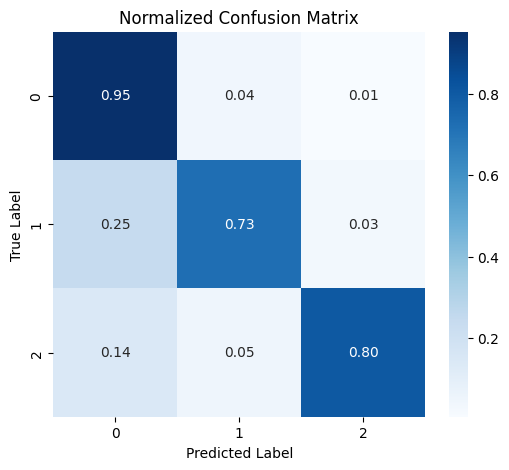

In [50]:
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()